In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('600703', start='2021-07-30', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
139,2021-07-30,40.901,42.481,43.461,40.511,2071444.0,600703
140,2021-08-02,42.311,40.901,43.671,40.101,1749153.0,600703
141,2021-08-03,40.401,40.741,43.551,40.101,2004500.0,600703
142,2021-08-04,40.751,44.821,44.821,40.401,2092180.0,600703
143,2021-08-05,44.211,43.231,44.701,42.771,1404100.0,600703
...,...,...,...,...,...,...,...
238,2021-12-27,37.351,37.201,37.471,36.571,458533.0,600703
239,2021-12-28,37.481,36.571,37.481,36.101,519855.0,600703
240,2021-12-29,36.441,35.601,36.751,35.411,470767.0,600703
241,2021-12-30,35.621,36.641,37.201,35.621,497335.0,600703


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
139,40.901,42.481
140,42.311,40.901
141,40.401,40.741
142,40.751,44.821
143,44.211,43.231
...,...,...
238,37.351,37.201
239,37.481,36.571
240,36.441,35.601
241,35.621,36.641


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.75927273, 0.83704735],
       [0.86181818, 0.7270195 ],
       [0.72290909, 0.71587744],
       [0.74836364, 1.        ],
       [1.        , 0.88927577],
       [0.95709091, 0.81058496],
       [0.77236364, 0.72562674],
       [0.71563636, 0.73885794],
       [0.74836364, 0.70194986],
       [0.71563636, 0.72075209],
       [0.72872727, 0.63300836],
       [0.61381818, 0.63649025],
       [0.65745455, 0.46935933],
       [0.53381818, 0.42618384],
       [0.46836364, 0.44568245],
       [0.45236364, 0.44289694],
       [0.46836364, 0.57103064],
       [0.59127273, 0.57381616],
       [0.632     , 0.53760446],
       [0.56218182, 0.45612813],
       [0.45890909, 0.42827298],
       [0.46472727, 0.38718663],
       [0.38109091, 0.40041783],
       [0.25236364, 0.23189415],
       [0.22836364, 0.19986072],
       [0.17818182, 0.17200557],
       [0.20290909, 0.24442897],
       [0.23563636, 0.24512535],
       [0.25163636, 0.24651811],
       [0.25818182, 0.20543175],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(78, 2)
(26, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(58, 14, 2)
(58, 1)
(6, 14, 2)
(6, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.1609 - val_loss: 0.1541
Epoch 2/10
1/1 [==============================] - 0s 94ms/step - loss: 0.1323 - val_loss: 0.1261
Epoch 3/10
1/1 [==============================] - 0s 124ms/step - loss: 0.1086 - val_loss: 0.1002
Epoch 4/10
1/1 [==============================] - 0s 104ms/step - loss: 0.0869 - val_loss: 0.0768
Epoch 5/10
1/1 [==============================] - 0s 85ms/step - loss: 0.0692 - val_loss: 0.0572
Epoch 6/10
1/1 [==============================] - 0s 102ms/step - loss: 0.0512 - val_loss: 0.0442
Epoch 7/10
1/1 [==============================] - 0s 105ms/step - loss: 0.0440 - val_loss: 0.0408
Epoch 8/10
1/1 [==============================] - 0s 106ms/step - loss: 0.0508 - val_loss: 0.0443
Epoch 9/10
1/1 [==============================] - 0s 93ms/step - loss: 0.0650 - val_loss: 0.0458
Epoch 10/10
1/1 [==============================] - 0s 98ms/step - loss: 0.0584 - val_loss: 0.0442


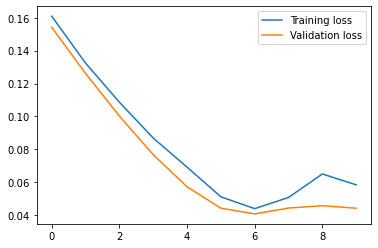

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 2s 2s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48747/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

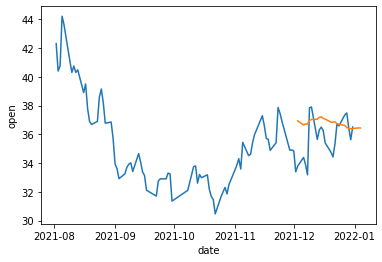

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [197]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result.to_csv("600703_SAGD.csv")

In [15]:
df.to_csv("600703_SAGD.csv")